# IUM - Etap 1
Wiktor Kulesza 304050

Jakub Tomaszewski 307322

## Definicja problemu biznesowego
Aktualnie właściciel sklepu zmaga się z problemem magazynowania produktów. Pracownicy magazynu nie są w stanie przewidzieć nadchodzącej ilości zwrotów co negatywnie wpływa na ich czas realizacji. 
Jako grupa analityków zamierzamy zoptymalizować ten koszt czasowy wprowadzając narzędzie, które będzie przewidywać ilość zwrotów w danym dniu. Docelowe rozwiązanie będzie przewidywać ilości na 14 dni w przód od obecnej daty.


---


## Definicja zadania modelowania
Bazując na charakterystyce problemu nękającego firmę wiemy, że utworzymy model szeregów czasowych. Będziemy przewidywać ilość nadchodzacych zwrotów na podstawie przeszłości


---


## Kryteria sukcesu
### Biznesowe
Zmniejszenie czasu realizacji zwrotów.
### Analityczne
Przewidywanie ilości zwrotów z dokładnością do 15 zwrotów na 2 tyg.


---


## Założenia
*   Dokładność predykcji do 1 dnia
*   Przewidywanie zwrotów na 2 tygodnie wprzód 
*   Zwroty mogą być realizowane do 30 dni
*   Model powinien posiadać możliwość cyklicznego douczenia się
*   Rozważamy jedynie zalogowanych użytkowników
*   Przyjęty średni czas dostawy wynoszący alfa (który będzie średnią arytmetyczną albo medianą czasu wszystkich dostaw)


---


##Dostępne dane:
1.   baza użytkowników,
2.   katalog produktów,
3.   historia sesji użytkowników,
4.   dane dotyczące wysyłki zakupionych produktów.


##Wstępne dane wejściowe:
*   Sessions:
> *   timestamp
> *   event_type
> *   product_id
*   Products:
> *   product_id
> *   category_path
> *   price
> *   brand
> *   weight_kg
> *   optional_attributes
*   Users:
> *   user_id
> *   city



##Dane wyjściowe:
Lista dni oraz miesięcy wraz z liczbą przewidywanych zwrotów



#Wczytanie danych

W tym miejscu wczytujemy do zmiennych najnowsze udostępnione nam dane.

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
DATA_DIR = 'data'

In [15]:
data_files = os.listdir(DATA_DIR)
data_files

['deliveries.jsonl', 'sessions.jsonl', 'products.jsonl', 'users.jsonl']

In [16]:
os.path.join(DATA_DIR, data_files[0])

'data/deliveries.jsonl'

In [21]:
df_deliveries = pd.read_json(os.path.join(DATA_DIR, data_files[0]), lines=True)
df_sessions = pd.read_json(os.path.join(DATA_DIR, data_files[1]), lines=True)
df_products = pd.read_json(os.path.join(DATA_DIR, data_files[2]), lines=True)
df_users = pd.read_json(os.path.join(DATA_DIR, data_files[3]), lines=True)

# Analiza danych

Pierwsza analiza danych uwidoczniła braki oraz niepoprawne wartości atrybutów takie jak:

*   ceny oraz wagi produktów, które często były ujemne, zerowe bądź nierozsądnie duże
*   niektóre rekordy dostaw nie miały podanej firmy odpowiedzialnej za tę dostawę
*   znaczna częśc dostaw nie miała wpisanej daty dostarczenia, co po analizie z klientem uznaliśmy za bląd danych

Następnie otrzymaliśmy poprawione dane, które poddaliśmy ponownej analizie.
Analizę tę rozpoczęliśmy od produktów.

- ## Products

In [22]:
df_products.head()

,product_id,product_name,category_path,price,brand,weight_kg,optional_attributes
0,1001,Fotel gamingowy Sofotel Cerber,"Akcesoria (Laptop, PC);Fotele gamingowe",619.99,Sofotel,19.0,{}
1,1002,Fotel gamingowy Sofotel Cerber,"Akcesoria (Laptop, PC);Fotele gamingowe",599.99,Sofotel,19.0,{}
2,1003,Fotel gamingowy TopEshop DORY,"Akcesoria (Laptop, PC);Fotele gamingowe",379.00,TopEshop,30.0,{}
3,1004,Fotel gamingowy Diablo Chairs WHITE BIEL BIAŁY,"Akcesoria (Laptop, PC);Fotele gamingowe",197.00,Diablo Chairs,30.0,{}
4,1005,Fotel gamingowy STERNHOFF SDH 162 B+B,"Akcesoria (Laptop, PC);Fotele gamingowe",399.00,STERNHOFF,17.0,{}


In [23]:
df_products.describe()

,product_id,price,weight_kg
count,653.000000,653.000000,653.000000
mean,1327.000000,283.225804,3.923240
std,188.649145,264.330061,16.456905
min,1001.000000,0.000000,0.000000
25%,1164.000000,68.600000,0.114000
50%,1327.000000,174.950000,0.300000
75%,1490.000000,429.000000,3.580000
max,1653.000000,999.000000,300.000000


Jak udało nam się zauważyć nowo dostarczone dane nie posiadają już wartości ujemnych oraz ceny wydają się być racjonalne (brak bardzo wysokich cen). Dodatkowo nie brakuje żadnych danych atrybutów oraz wiemy z jakim typem danych będziemy pracować, co widać w niżej załączonej komórce 

In [24]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           653 non-null    int64  
 1   product_name         653 non-null    object 
 2   category_path        653 non-null    object 
 3   price                653 non-null    float64
 4   brand                653 non-null    object 
 5   weight_kg            653 non-null    float64
 6   optional_attributes  653 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 35.8+ KB


In [25]:
sorted(df_products.brand.unique())

['A4TECH',
 'A4Tech',
 'ADATA',
 'AOC',
 'ART',
 'ASUS',
 'Acer',
 'Alio',
 'Angel',
 'Apacer',
 'Apple',
 'Asus',
 'BenQ',
 'Blow',
 'Brother',
 'CRUCIAL',
 'Cooler Master',
 'Corsair',
 'Creative',
 'Defender',
 'Dell',
 'Diablo Chairs',
 'ELPIDA',
 'Epson',
 'Esperanza',
 'Fury',
 'G.SKILL',
 'GIGABYTE',
 'GOODRAM',
 'Gembird',
 'Genesis',
 'Giosedio',
 'Goodram',
 'HP',
 'Hikvision',
 'Huawei',
 'Huzaro',
 'HyperX',
 'IMILAB',
 'Ipega',
 'Jabra',
 'Kingston',
 'LG',
 'Lenovo',
 'Logitech',
 'MSI',
 'Malatec',
 'Marvo',
 'Media-Tech',
 'Micron',
 'Microsoft',
 'Modecom',
 'Mozos',
 'Natec',
 'Onikuma',
 'PNY',
 'Patriot',
 'Philips',
 'Qoltec',
 'Ramaxel',
 'Rapoo',
 'Razer',
 'Red Fighter',
 'Roccat',
 'SK Hynix',
 'SPC GEAR',
 'SPC Gear',
 'STERNHOFF',
 'Samsung',
 'SanDisk',
 'Sennheiser',
 'Sharkoon',
 'Sofotel',
 'SpeedLink',
 'SteelSeries',
 'Thrustmaster',
 'Titanum',
 'TopEshop',
 'Tracer',
 'Trust',
 'Unitek',
 'Xiaomi',
 'eHokery',
 'iBox',
 'iMICE',
 'iiyama',
 'retoo',
 

Problem, którego nie udało się wyeliminować w nowej paczce danych były powtarzające się nazwy firm produkujących dostępne w sklepie produkty. Problem ten zamierzamy rozwiązać sprowadzając nazwy firm do małych liter. Poniżej lista powtarzających się firm: 
- `A4TECH`
- `A4Tech`
- `ASUS`
- `asus`
- `GOODRAM`
- `Goodram`
- `SPC GEAR`
- `SPC Gear`

Funkcja - toLower()

In [26]:
df_products['brand'] = df_products['brand'].apply(lambda x: x.lower())

In [27]:
df_products['category_path'].unique()

array(['Akcesoria (Laptop, PC);Fotele gamingowe',
       'Akcesoria (Laptop, PC);Kamery internetowe',
       'Części do laptopów;Pamięć RAM', 'Części i akcesoria;Matryce LCD',
       'Części i akcesoria;Zasilacze LCD',
       'Kable i przedłużacze;DisplayPort', 'Klawiatury;Bezprzewodowe',
       'Klawiatury;Przewodowe', 'Komputery;Komputery stacjonarne',
       'Mikrofony i słuchawki;Słuchawki bezprzewodowe',
       'Mikrofony i słuchawki;Słuchawki przewodowe',
       'Monitory komputerowe;Monitory', 'Myszki;Bezprzewodowe',
       'Myszki;Przewodowe', 'Pamięci przenośne;Pendrive',
       'Podzespoły komputerowe;Pamięć RAM', 'Skanery;Płaskie USB',
       'Skanery;Profesjonalne', 'Tablety;Urządzenia',
       'Urządzenia VR;Gogle VR', 'Urządzenia wskazujące;Pady',
       'Zestaw klawiatura i mysz;Bezprzewodowe',
       'Zestaw klawiatura i mysz;Przewodowe'], dtype=object)

Podobne porównanie w celu wykrycia duplikatów przeprowadziliśmy na kategoriach produktów, lecz w tym przypadków nie spotkaliśmy się z podobnym problemem.

- ## Sessions data

Następnie zabraliśmy się za analizę rekordów sesji, w szczególności będziemy chcieli przyjrzeć się sesjom zwrotów, które mogą być bardzo przydatne w późniejszej estymacji ilości zwrotów.

In [28]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2020-01-25 19:25:15,102,1538,VIEW_PRODUCT,5.0,NaN
1,124,2020-01-25 19:26:12,102,1542,VIEW_PRODUCT,5.0,NaN
2,124,2020-01-25 19:30:49,102,1539,VIEW_PRODUCT,5.0,NaN
3,124,2020-01-25 19:35:40,102,1541,VIEW_PRODUCT,5.0,NaN
4,124,2020-01-25 19:39:26,102,1547,VIEW_PRODUCT,5.0,NaN


Postanowiliśmy również tym razem sprawdzić z jakim typem danych mamy doczynienia oraz czy nie brakuje jakichkolwiek wartości atrybutów w nowej paczce danych.

In [29]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99204 entries, 0 to 99203
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        99204 non-null  int64         
 1   timestamp         99204 non-null  datetime64[ns]
 2   user_id           99204 non-null  int64         
 3   product_id        99204 non-null  int64         
 4   event_type        99204 non-null  object        
 5   offered_discount  97543 non-null  float64       
 6   purchase_id       15859 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 5.3+ MB


In [30]:
df_sessions['event_type'].value_counts()

VIEW_PRODUCT      83345
BUY_PRODUCT       14198
RETURN_PRODUCT     1661
Name: event_type, dtype: int64

Jak widzimy wyżej dane dotyczące sesji nie mają brakujących wartości atrybutów oraz posiadają rekordy dotyczące zwrotów które stanowią około 1,5% wszystkich sesji. Postanowiliśmy przyjrzeć się bliżej temu typowi sesji.

In [31]:

df_return_sessions = df_sessions[df_sessions['event_type'] == 'RETURN_PRODUCT']
df_return_sessions.head(10)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
7,125,2020-02-08 09:00:56.623825,102,1546,RETURN_PRODUCT,NaN,20001.0
49,139,2020-10-14 15:36:40.396254,102,1603,RETURN_PRODUCT,NaN,20010.0
134,163,2021-11-27 14:01:22.948100,103,1330,RETURN_PRODUCT,NaN,20024.0
164,170,2021-12-07 22:33:20.878858,103,1200,RETURN_PRODUCT,NaN,20028.0
177,174,2020-10-18 19:58:58.170940,103,1543,RETURN_PRODUCT,NaN,20031.0
278,197,2021-11-29 13:08:58.459805,103,1610,RETURN_PRODUCT,NaN,20046.0
297,202,2022-02-16 17:40:07.485396,103,1095,RETURN_PRODUCT,NaN,20049.0
319,209,2021-11-30 05:57:00.968747,103,1610,RETURN_PRODUCT,NaN,20053.0
336,213,2021-02-21 04:05:53.790189,103,1608,RETURN_PRODUCT,NaN,20056.0
544,252,2022-01-27 01:15:15.171814,105,1616,RETURN_PRODUCT,NaN,20084.0


In [32]:
df_return_sessions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1661 entries, 7 to 99139
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        1661 non-null   int64         
 1   timestamp         1661 non-null   datetime64[ns]
 2   user_id           1661 non-null   int64         
 3   product_id        1661 non-null   int64         
 4   event_type        1661 non-null   object        
 5   offered_discount  0 non-null      float64       
 6   purchase_id       1661 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 103.8+ KB


In [33]:
df_return_sessions.isna().sum()

session_id             0
timestamp              0
user_id                0
product_id             0
event_type             0
offered_discount    1661
purchase_id            0
dtype: int64

Postanowiliśmy również sprawdzić liczbę rodzajów produktów, które ulegają zwrotom oraz zakupom. Przy budowaniu modelu trzeba będzie zwrócić uwagę na to jaki procent kupionego danego produktu podlega zwrotowi.

In [34]:
#sprawdzamy ile różnych produktów jest oglądanych/zamawianych/zwracanych
df_sessions['product_id'].nunique()

164

In [35]:
#sprawdzamy ile różnych produktów jest zwracanych
df_return_sessions['product_id'].nunique()

164

Możemy zauważyć, że rekordy dotyczące zwrotu są poprawne. Wszystkie jednak posiadają kolumnę dotyczącą zaoferowanej zniżki, która w tym kontekście nie ma żadnego sensu, dlatego w ramach dalszej analizy zwrotów postanowiliśmy pominąć tę kolumnę.

Removing redundant `offered discount` column

In [36]:
df_sessions = df_sessions.drop('offered_discount', axis=1)
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,purchase_id
0,124,2020-01-25 19:25:15,102,1538,VIEW_PRODUCT,NaN
1,124,2020-01-25 19:26:12,102,1542,VIEW_PRODUCT,NaN
2,124,2020-01-25 19:30:49,102,1539,VIEW_PRODUCT,NaN
3,124,2020-01-25 19:35:40,102,1541,VIEW_PRODUCT,NaN
4,124,2020-01-25 19:39:26,102,1547,VIEW_PRODUCT,NaN


Zmieniliśmy również kolumnę z datą w celu dalszej analizy

In [37]:
df_sessions['timestamp'] = pd.to_datetime(df_sessions['timestamp']).dt.date.astype('datetime64[ns]')
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,purchase_id
0,124,2020-01-25,102,1538,VIEW_PRODUCT,NaN
1,124,2020-01-25,102,1542,VIEW_PRODUCT,NaN
2,124,2020-01-25,102,1539,VIEW_PRODUCT,NaN
3,124,2020-01-25,102,1541,VIEW_PRODUCT,NaN
4,124,2020-01-25,102,1547,VIEW_PRODUCT,NaN


In [38]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99204 entries, 0 to 99203
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   session_id   99204 non-null  int64         
 1   timestamp    99204 non-null  datetime64[ns]
 2   user_id      99204 non-null  int64         
 3   product_id   99204 non-null  int64         
 4   event_type   99204 non-null  object        
 5   purchase_id  15859 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 4.5+ MB


- ## Users

Nastepnie postanowiliśmy sprawdzić dane o klientach oraz ich poprawność. Mamy przeczucie, że miejsce zamieszkania klientów może mieć wpływ na ilość zwrotów (nawet jeżeli nie bezpośredni)

In [39]:
df_users

,user_id,name,city,street
0,102,Sebastian Młyńczak,Szczecin,pl. Pałacowa 584
1,103,Karina Dąbrowicz,Radom,plac Polna 13
2,104,Konrad Żelazek,Wrocław,al. Młyńska 53/86
3,105,Bruno Baumgart,Szczecin,plac Narcyzowa 29
4,106,Karina Grygorowicz,Poznań,ul. Chopina 24
...,...,...,...,...
395,497,Dagmara Macek,Szczecin,al. Sowia 32/70
396,498,Hubert Kamela,Kraków,ul. Jana III Sobieskiego 38/78
397,499,Sonia Szabla,Radom,ulica Strażacka 43
398,500,Natasza Kułach,Warszawa,plac Poniatowskiego 382


Wartościowe atrybuty:
- user_id
- city (optional)

In [40]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  400 non-null    int64 
 1   name     400 non-null    object
 2   city     400 non-null    object
 3   street   400 non-null    object
dtypes: int64(1), object(3)
memory usage: 12.6+ KB


Jak widzimy nie brakuje danych o miejscu zamieszkania ani o identyfikatorach użytkowników.

- ## Deliveries

Uważamy, że dane dotyczące dostaw mogą mieć znaczy wpływ na estymację ilości zwrotów w przyszłości. Przede wszystkim na podstawie tych danych określimy średni czas dostarczenia zwrotów który posłuży nam do przybliżenia czasu dotarcia zwrotu do magazynu 

In [41]:
pd.set_option('display.max_rows', 500)

In [42]:
df_deliveries

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2020-01-25T19:40:37,2020-01-30T19:40:44,516
1,20002,2019-12-29T16:12:47,2019-12-31T16:13:40,516
2,20003,2020-12-30T07:28:26,2021-01-01T07:29:45,516
3,20004,2020-04-13T06:30:14,2020-04-16T06:33:45,620
4,20005,2022-03-15T11:36:49,2022-03-20T11:38:02,516
...,...,...,...,...
14193,34194,2020-09-27T02:52:41,2020-09-29T02:54:11,620
14194,34195,2021-07-30T06:49:04,2021-08-03T06:51:27,360
14195,34196,2020-04-02T19:13:41,2020-04-07T19:18:14,620
14196,34197,2021-08-05T02:16:49,2021-08-10T02:18:11,620


In [43]:
df_deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14198 entries, 0 to 14197
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   purchase_id         14198 non-null  int64 
 1   purchase_timestamp  14198 non-null  object
 2   delivery_timestamp  14198 non-null  object
 3   delivery_company    14198 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 443.8+ KB


Jak widzimy po aktualizacji danych nie brakuje żadnych danych dotyczących przesyłek w tym, czasu dostarczenia paczki oraz numeru firmy przewozowej.

Dodatkowo konwertujemy kolumny do typu datetime z samą datą.

In [44]:
df_deliveries[['purchase_timestamp', 'delivery_timestamp']] = df_deliveries[['purchase_timestamp', 'delivery_timestamp']].apply(pd.to_datetime)
df_deliveries['purchase_timestamp'] = df_deliveries['purchase_timestamp'].dt.date
df_deliveries['delivery_timestamp'] = df_deliveries['delivery_timestamp'].dt.date
df_deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2020-01-25,2020-01-30,516
1,20002,2019-12-29,2019-12-31,516
2,20003,2020-12-30,2021-01-01,516
3,20004,2020-04-13,2020-04-16,620
4,20005,2022-03-15,2022-03-20,516


Sprawdzamy czasy poszczególnych przesyłek

In [45]:
df_deliveries['delivery_timestamp'] - df_deliveries['purchase_timestamp']

0       5 days
1       2 days
2       2 days
3       3 days
4       5 days
         ...  
14193   2 days
14194   4 days
14195   5 days
14196   5 days
14197   2 days
Length: 14198, dtype: timedelta64[ns]

In [46]:
df_deliveries.groupby('delivery_company').count()

,purchase_id,purchase_timestamp,delivery_timestamp
delivery_company,,,
360,4881,4881,4881
516,4554,4554,4554
620,4763,4763,4763


Myśleliśmy, że dobrym pomysłem będzie wyliczenie średniej ważonej czasu trwania dostarczania paczek, lecz wszystkie firmy odpowiedzialne są praktycznie za ten sam procent przesyłek przez co postanowiliśmy zrezygnować z tego pomysłu i pozostać przy zwykłej średniej arytmetycznej, bądź medianie.

## Dalsza analiza danych
Po wstępnym określeniu poprawności danych postanowiliśmy przyjrzeć się rozkładom niektórych atrybutów oraz sprawdzić czy dostarczone dane wystarczą by utworzyć wiarygodny model.

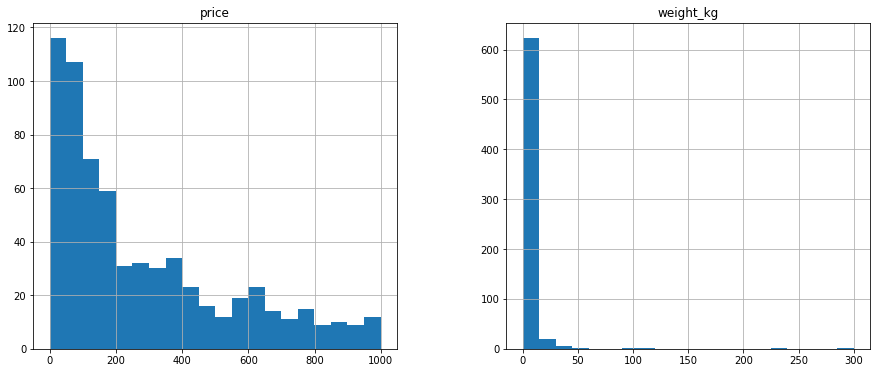

In [61]:
df_products[['price', 'weight_kg']].hist(bins=20, figsize=(15, 6))
plt.show()

Widzimy wyżej że ceny produktów mają najprawdopodobniej rozkład wykładniczy. Natomiast wagi produktów skupione są głównie w 1 małym przedziale w którym znajduje się znaczna większość produktów.

Dodatkowo sprawdziliśmy okres jakiego dotyczą nasze dane dotyczące sesji. W celu zbudowania wiarygodnego modelu potrzebujemy danych z całego roku, a najlepiej z kilku lat. Po sprawdzeniu tego, dowiedzieliśmy się że nasze dane dotyczą tylko 4 miesięcy, dlatego zwróciliśmy się do klienta z prośbą o dostarczenie większej ilości danych historycznych. Następnie ponownie sprawdziliśmy czy mamy doczynienia z danymi z  minimum całego roku.

## Ilość zamówień i zwrotów w każdym miesiącu

Sprawdzamy najwcześniejszą oraz najpóźniejszą datę zamówienia wraz z dostawą

In [48]:
df_deliveries[['purchase_timestamp', 'delivery_timestamp']].min()

purchase_timestamp    2019-08-01
delivery_timestamp    2019-08-03
dtype: object

In [49]:
df_deliveries[['purchase_timestamp', 'delivery_timestamp']].max()

purchase_timestamp    2022-04-12
delivery_timestamp    2022-04-17
dtype: object

Jak widzimy mamy dane z prawie 3 lat, co pozwoli nam zbudować wiarygodny model

In [50]:
df_sessions_analysis = df_sessions[['timestamp', 'event_type']]
df_sessions_analysis[(df_sessions_analysis['event_type'] == 'RETURN_PRODUCT') | (df_sessions_analysis['event_type'] == 'BUY_PRODUCT')]

,timestamp,event_type
6,2020-01-25,BUY_PRODUCT
7,2020-02-08,RETURN_PRODUCT
14,2019-12-29,BUY_PRODUCT
16,2020-12-30,BUY_PRODUCT
20,2020-04-13,BUY_PRODUCT
...,...,...
99159,2020-09-27,BUY_PRODUCT
99176,2021-07-30,BUY_PRODUCT
99188,2020-04-02,BUY_PRODUCT
99197,2021-08-05,BUY_PRODUCT


In [51]:
df_sessions_analysis['month'] = df_sessions_analysis['timestamp'].dt.month
df_sessions_analysis

/home/kuba/PW/IUM/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,timestamp,event_type,month
0,2020-01-25,VIEW_PRODUCT,1
1,2020-01-25,VIEW_PRODUCT,1
2,2020-01-25,VIEW_PRODUCT,1
3,2020-01-25,VIEW_PRODUCT,1
4,2020-01-25,VIEW_PRODUCT,1
...,...,...,...
99199,2021-03-13,VIEW_PRODUCT,3
99200,2021-03-13,VIEW_PRODUCT,3
99201,2021-03-13,VIEW_PRODUCT,3
99202,2021-03-13,VIEW_PRODUCT,3


Pogrupowaliśmy dane ze względu na datę by sprawdzić ilość danych na przestrzeni czasu

In [52]:
df_sessions_analysis[['event_type', 'month']]

,event_type,month
0,VIEW_PRODUCT,1
1,VIEW_PRODUCT,1
2,VIEW_PRODUCT,1
3,VIEW_PRODUCT,1
4,VIEW_PRODUCT,1
...,...,...
99199,VIEW_PRODUCT,3
99200,VIEW_PRODUCT,3
99201,VIEW_PRODUCT,3
99202,VIEW_PRODUCT,3


In [53]:
monthly_analysis = pd.get_dummies(df_sessions_analysis[['event_type', 'month']], columns=['event_type'])
monthly_analysis

,month,event_type_BUY_PRODUCT,event_type_RETURN_PRODUCT,event_type_VIEW_PRODUCT
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,0,0,1
...,...,...,...,...
99199,3,0,0,1
99200,3,0,0,1
99201,3,0,0,1
99202,3,0,0,1


Stworzyliśmy kolejną zmienną która pomoże wyliczyć nam ilość wszelkiego rodzaju zamówień ze względu na miesiąc. Poniżej wykres przedstawiający ilość wszystkich sesji ze względu na miesiąc. Jak widzimu okres od maja do lipca charakteryzuje się najmniejszą ilością sesji.

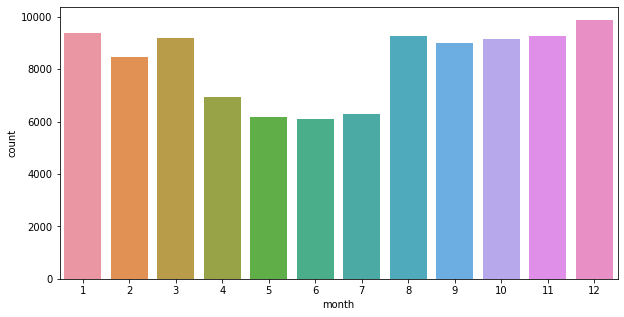

In [64]:
plt.figure(figsize=(10, 5))
sns.countplot(x='month', data=monthly_analysis)
plt.show()

---

In [67]:
df_sessions_analysis.drop('month', axis=1)

,timestamp,event_type
0,2020-01-25,VIEW_PRODUCT
1,2020-01-25,VIEW_PRODUCT
2,2020-01-25,VIEW_PRODUCT
3,2020-01-25,VIEW_PRODUCT
4,2020-01-25,VIEW_PRODUCT
...,...,...
99199,2021-03-13,VIEW_PRODUCT
99200,2021-03-13,VIEW_PRODUCT
99201,2021-03-13,VIEW_PRODUCT
99202,2021-03-13,VIEW_PRODUCT


In [86]:
num_events_by_month = pd.get_dummies(df_sessions_analysis.drop('month', axis=1)).groupby('timestamp').sum()
num_events_by_month.head()

,event_type_BUY_PRODUCT,event_type_RETURN_PRODUCT,event_type_VIEW_PRODUCT
timestamp,,,
2019-08-01,15,0,91
2019-08-02,19,0,100
2019-08-03,14,0,75
2019-08-04,17,0,87
2019-08-05,15,0,96


Text(0.5, 1.0, 'Number of events each month')

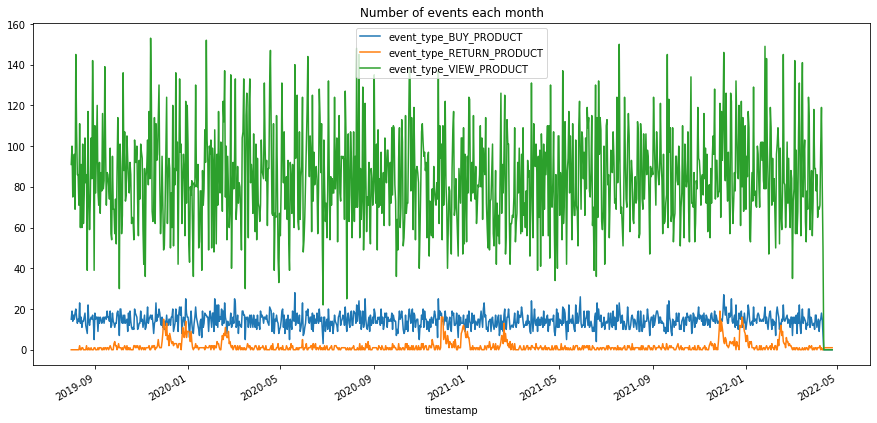

In [111]:
num_events_by_month.plot(figsize=(15, 7))
plt.title('Number of events each month')

Na podstawie powyższego wykresu można zauważyć, że zwroty są najrzadzieć zdarząjącymi się operacjami.
Można ponadto zauważyć, że najwięcej zwrotów ma miejsce pod koniec i na początku każdego roku. Jest to wielokrotnie powtarzająca się zależność.

---

Na końcu postanowiliśmy oddzielnie sprawdzić każdy rodzaj transakcji tzn. sesje kupna oraz zwrotu.

In [55]:
monthly_analysis = pd.get_dummies(df_sessions_analysis[['event_type', 'month']], columns=['event_type'])
grouped_monthly_analysis = monthly_analysis.groupby('month').sum()
grouped_monthly_analysis

,event_type_BUY_PRODUCT,event_type_RETURN_PRODUCT,event_type_VIEW_PRODUCT
month,,,
1,1337.0,169.0,7882.0
2,1225.0,279.0,6959.0
3,1330.0,75.0,7795.0
4,1009.0,57.0,5894.0
5,891.0,46.0,5250.0
6,835.0,54.0,5215.0
7,879.0,46.0,5361.0
8,1357.0,58.0,7861.0
9,1299.0,81.0,7641.0


In [305]:
grouped_monthly_analysis

,event_type_BUY_PRODUCT,event_type_RETURN_PRODUCT,event_type_VIEW_PRODUCT
month,,,
1,1337.0,169.0,7882.0
2,1225.0,279.0,6959.0
3,1330.0,75.0,7795.0
4,1009.0,57.0,5894.0
5,891.0,46.0,5250.0
6,835.0,54.0,5215.0
7,879.0,46.0,5361.0
8,1357.0,58.0,7861.0
9,1299.0,81.0,7641.0


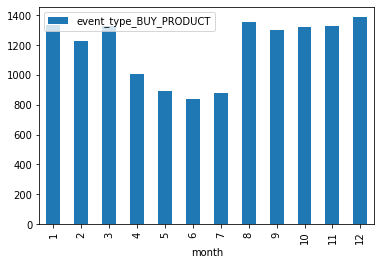

In [306]:
grouped_monthly_analysis[['event_type_BUY_PRODUCT']].plot(kind='bar')

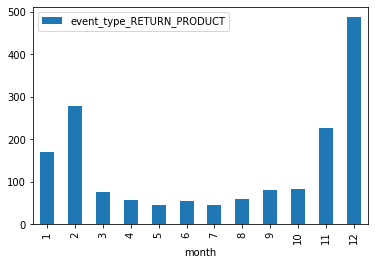

In [307]:
grouped_monthly_analysis[['event_type_RETURN_PRODUCT']].plot(kind='bar')

Jak możemy zauważyć grudzień oraz luty są miesiącami w których najwięcej paczek zostaje zwróconych co wydaje się logiczne ze względu na zakupy świąteczne oraz walentynki

Jak widzimy wyżej nasza analiza dostarczonych danych pozwoli nam wziąć odpowiednie atrybuty pod uwagę przy budowie modelu i lepiej estymować ilość nadchodzących zwrotów.